In [19]:
from diffusers import DiffusionPipeline, DDIMScheduler
from transformers import CLIPTextModel
import torch, PIL, requests
from io import BytesIO
from IPython.display import display
import os

In [20]:
def center_crop_and_resize(im):

    width, height = im.size
    d = min(width, height)
    left = (width - d) / 2
    upper = (height - d) / 2
    right = (width + d) / 2
    lower = (height + d) / 2

    return im.crop((left, upper, right, lower)).resize((512, 512))

In [21]:
torch_dtype = torch.float16
# Set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [22]:
# scheduler and text_encoder param values as in the paper
scheduler = DDIMScheduler(
        num_train_timesteps=1000,
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        set_alpha_to_one=False,
        clip_sample=False,
)

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path="openai/clip-vit-large-patch14",
    torch_dtype=torch_dtype,
)



# EDICT Pipeline

This pipeline implements the text-guided image editing approach from the paper [EDICT: Exact Diffusion Inversion via Coupled Transformations](https://arxiv.org/abs/2211.12446).

In [36]:
# initialize pipeline
pipeline = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4",
    custom_pipeline="edict_pipeline",
    variant="fp16",
    scheduler=scheduler,
    text_encoder=text_encoder,
    leapfrog_steps=True,
    torch_dtype=torch_dtype,
).to(device)

/Users/surya/Documents/personal/kaggle/venv_kaggle/lib/python3.11/site-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

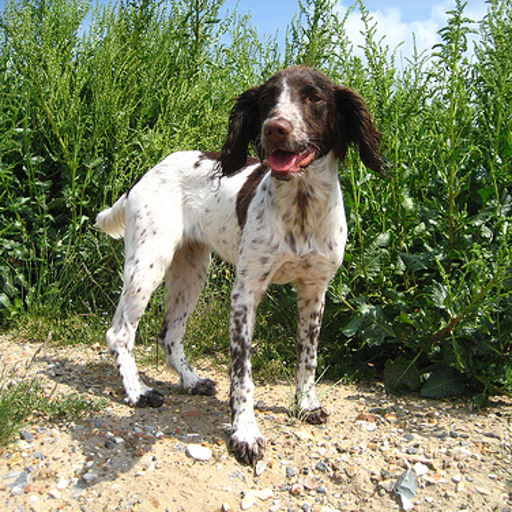

In [39]:
#image_location = 'macaw.jpg'
#image = PIL.Image.open(image_location)
# download image
image_url = "https://huggingface.co/datasets/Joqsan/images/resolve/main/imagenet_dog_1.jpeg"
response = requests.get(image_url)
image = PIL.Image.open(BytesIO(response.content))


cropped_image = center_crop_and_resize(image)
display(cropped_image)

In [40]:
base_prompt = 'a dog'
target_prompt = 'a husky'

# run the pipeline
result_image = pipeline(
      base_prompt=base_prompt,
      target_prompt=target_prompt,
      image=cropped_image,
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

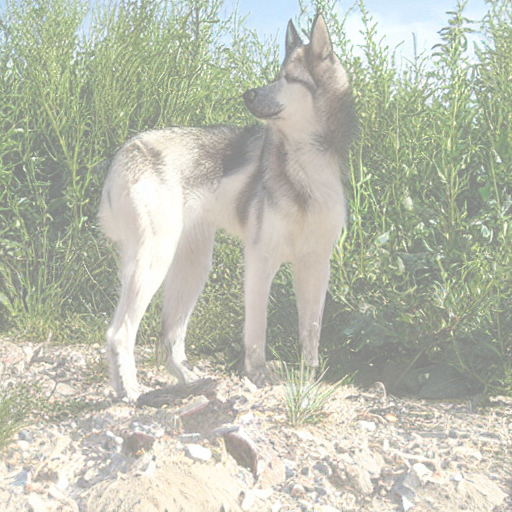

In [41]:
display(result_image[0])